# GAN на MNIST

В этом ноутбуке мы реализуем и обучим простую генеративно-состязательную сеть (GAN) для генерации изображений цифр из датасета MNIST.

**GAN (Generative Adversarial Network)** состоит из двух нейронных сетей:
- **Generator (Генератор)** - создает фейковые изображения из случайного шума
- **Discriminator (Дискриминатор)** - пытается отличить настоящие изображения от фейковых

Обе сети обучаются одновременно в состязательном процессе.


## Импорты


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import os

torch.manual_seed(42)
np.random.seed(42)
pl.seed_everything(42)


Seed set to 42


42

## Загрузка и визуализация датасета MNIST

Сначала загрузим датасет MNIST и посмотрим на примеры изображений.


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4
)


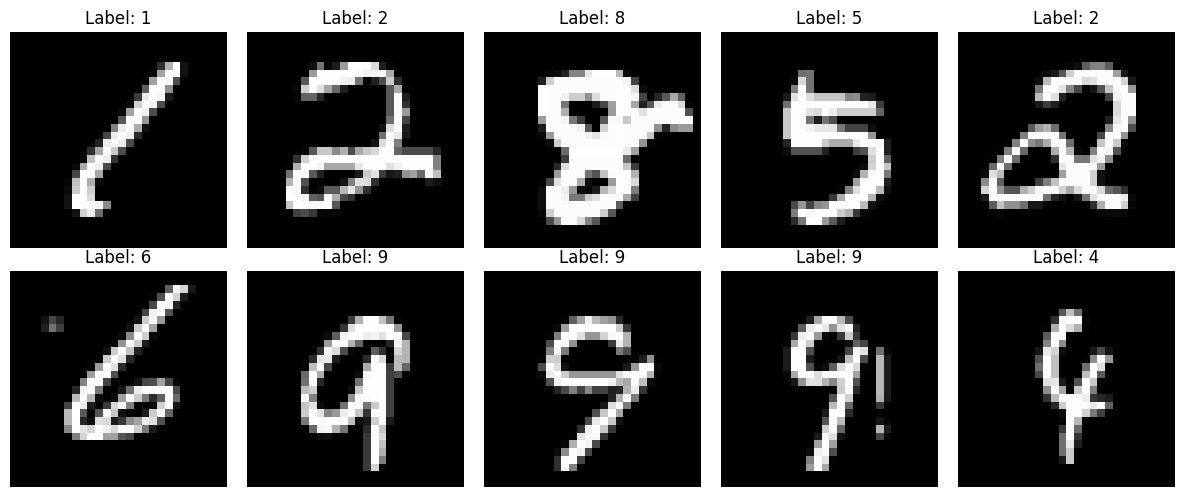

In [3]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    ax = axes[i // 5, i % 5]
    img = images[i].squeeze().numpy()
    img = (img + 1) / 2.0
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()


## Архитектура Generator

Генератор принимает случайный вектор (шум) размерности `latent_dim` и преобразует его в изображение 28x28 пикселей. Используем простую архитектуру с полносвязными слоями и активациями ReLU/Tanh.


In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img


## Архитектура Discriminator

Дискриминатор принимает изображение 28x28 и выдает вероятность того, что изображение настоящее (1) или сгенерированное (0). Используем полносвязные слои с LeakyReLU и Sigmoid на выходе.


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity


## PyTorch Lightning модуль для GAN

Создаем Lightning модуль, который объединяет генератор и дискриминатор, и реализует логику обучения GAN. В каждом шаге обучения:
1. Обучаем дискриминатор на настоящих и сгенерированных изображениях
2. Обучаем генератор, чтобы обмануть дискриминатор


In [6]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002, b1=0.5, b2=0.999):
        super().__init__()
        self.save_hyperparameters()
        
        self.automatic_optimization = False
        
        self.generator = Generator(latent_dim)
        self.discriminator = Discriminator()
        
        self.latent_dim = latent_dim
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        
        self.validation_z = torch.randn(64, latent_dim)
    
    def forward(self, z):
        return self.generator(z)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch
        opt_g, opt_d = self.optimizers()
        
        z = torch.randn(real_imgs.shape[0], self.latent_dim)
        z = z.type_as(real_imgs)
        
        opt_d.zero_grad()
        
        real_validity = self.discriminator(real_imgs)
        real_loss = self.adversarial_loss(
            real_validity,
            torch.ones(real_imgs.size(0), 1).type_as(real_imgs)
        )
        
        fake_imgs = self.generator(z).detach()
        fake_validity = self.discriminator(fake_imgs)
        fake_loss = self.adversarial_loss(
            fake_validity,
            torch.zeros(real_imgs.size(0), 1).type_as(real_imgs)
        )
        
        d_loss = (real_loss + fake_loss) / 2
        self.manual_backward(d_loss)
        opt_d.step()
        
        self.log('d_loss', d_loss, prog_bar=True)
        
        opt_g.zero_grad()
        
        fake_imgs = self.generator(z)
        g_loss = self.adversarial_loss(
            self.discriminator(fake_imgs),
            torch.ones(real_imgs.size(0), 1).type_as(real_imgs)
        )
        
        self.manual_backward(g_loss)
        opt_g.step()
        
        self.log('g_loss', g_loss, prog_bar=True)
    
    def configure_optimizers(self):
        opt_g = torch.optim.Adam(
            self.generator.parameters(),
            lr=self.lr,
            betas=(self.b1, self.b2)
        )
        opt_d = torch.optim.Adam(
            self.discriminator.parameters(),
            lr=self.lr,
            betas=(self.b1, self.b2)
        )
        return [opt_g, opt_d], []
    
    def on_train_epoch_end(self):
        z = self.validation_z.type_as(self.generator.model[0].weight)
        sample_imgs = self.generator(z)
        
        save_dir = 'generated_images'
        os.makedirs(save_dir, exist_ok=True)
        
        fig, axes = plt.subplots(8, 8, figsize=(12, 12))
        for i in range(64):
            ax = axes[i // 8, i % 8]
            img = sample_imgs[i].squeeze().detach().cpu().numpy()
            img = (img + 1) / 2.0
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'epoch_{self.current_epoch:03d}.png'))
        plt.close()
        
        if self.logger:
            grid = utils.make_grid(sample_imgs.detach(), nrow=8, normalize=True)
            self.logger.experiment.add_image('generated_images', grid, self.current_epoch)


## Обучение модели

Обучаем GAN на датасете MNIST. Используем callback для сохранения лучших чекпоинтов.


In [7]:
model = GAN(latent_dim=100, lr=0.0002)

checkpoint_callback = ModelCheckpoint(
    monitor='g_loss',
    mode='min',
    save_top_k=1,
    filename='gan-mnist-{epoch:02d}-{g_loss:.4f}'
)

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback],
    enable_progress_bar=True
)

trainer.fit(model, train_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 1.5 M  | train
1 | discriminator | Discriminator | 1.5 M  | train
--------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.786    Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=50` reached.


## Визуализация результатов

Генерируем изображения с помощью обученного генератора и визуализируем результаты.


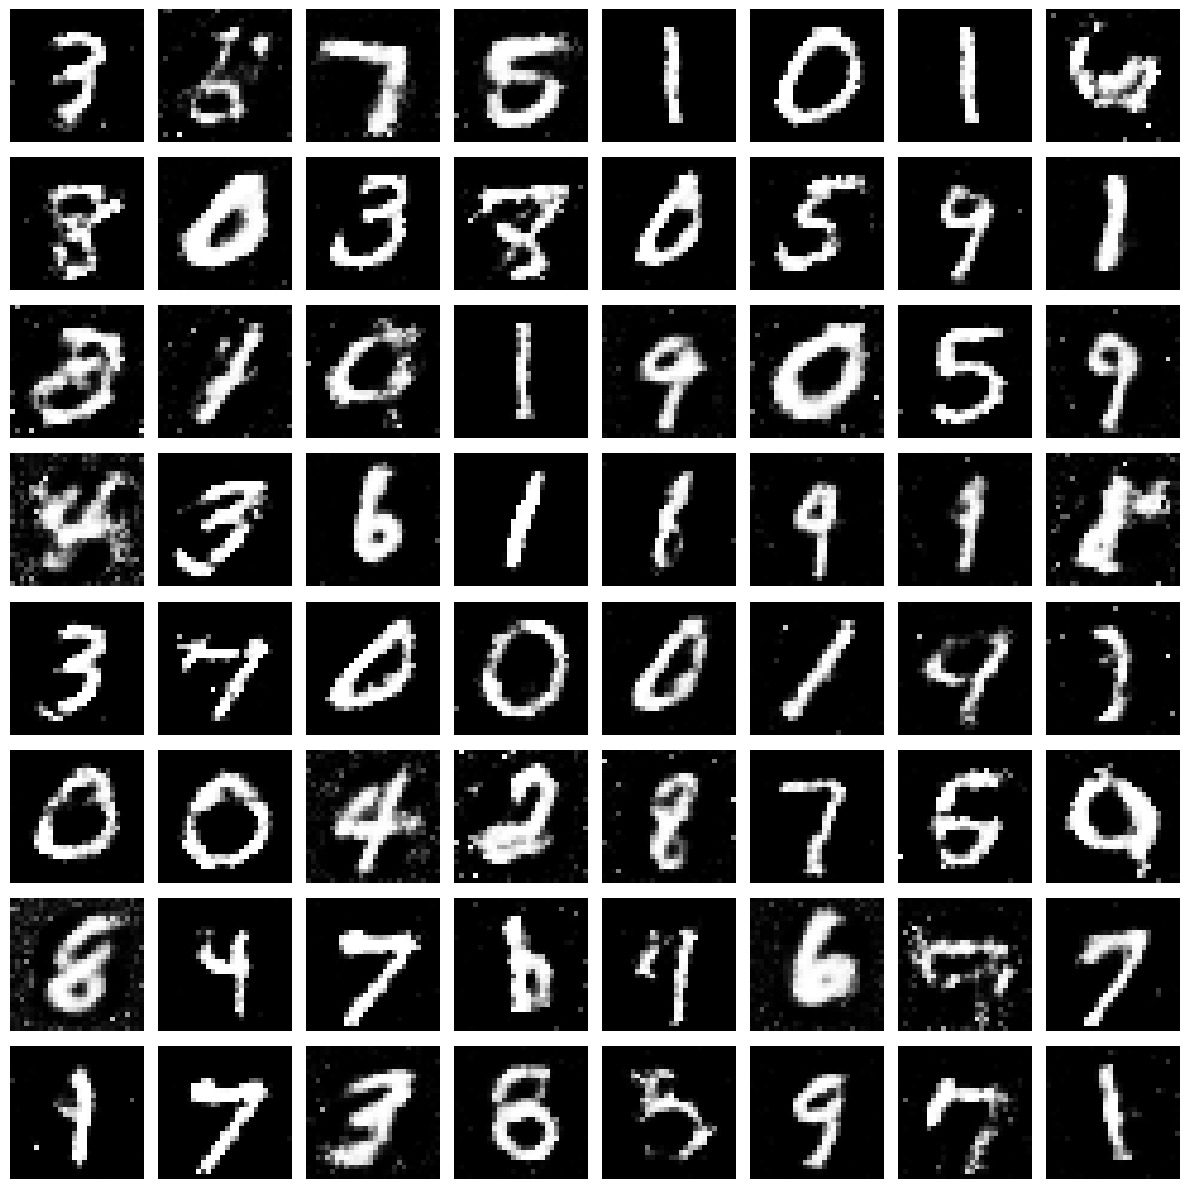

In [8]:
model.eval()
with torch.no_grad():
    z = torch.randn(64, 100)
    z = z.type_as(next(model.generator.parameters()))
    fake_imgs = model.generator(z)

fig, axes = plt.subplots(8, 8, figsize=(12, 12))
for i in range(64):
    ax = axes[i // 8, i % 8]
    img = fake_imgs[i].squeeze().cpu().numpy()
    img = (img + 1) / 2.0
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()
